In [1]:
from gurobipy import Model, quicksum, GRB
import importlib
import src.topo
importlib.reload(src.topo)
from src.topo import ChargingNetwork

import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
flight_time = np.array([[0,2,4,4,4,3],
                        [2,0,2,3,3,4],
                        [4,2,0,3,2,5],
                        [4,3,3,0,2,3],
                        [4,3,2,2,0,1],
                        [3,4,5,3,1,0]])
energy_consumption = flight_time * 2
od_matrix = np.array([[0,1,1,1,1,1],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [1,0,0,0,0,0]])


In [3]:
cn = ChargingNetwork(vertiports=['LAX', 'DTLA', 'LGB', 'WDHL', 'ELSG', 'US'],
                     flight_time=flight_time,
                     energy_consumption=energy_consumption,
                     od_matrix=od_matrix)
nodes, supply, edges, cost, c = cn.populate_network()

In [4]:
schedule = pd.read_csv("../input/schedule_5min_0612.csv")

In [8]:
topo = ChargingNetwork(vertiports=['LAX', 'DTLA'], 
                       flight_time=np.array([[0,2],[2,0]]), 
                       energy_consumption=np.array([[0,4],[4,0]]),
                       od_matrix=np.array([[0,1],[1,0]]))

In [9]:
nodes, supply, edges, cost, c = topo.populate_network()

In [10]:
K=32
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+2, k-4)] for k in range(4,K+1))

In [11]:
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+2, k-4)] for k in range(4,K))

In [12]:
schedule['schedule'] = schedule['schedule'] // 5
schedule['schedule'] = schedule['schedule'].astype(int)

In [13]:
grouped_schedule = schedule.groupby(['od', 'schedule']).size().reset_index()

In [14]:
flight_demand = {}
od_key = {'LAX': 0, 'DTLA': 1}
for i in range(len(grouped_schedule)):
    od, schedule, demand = grouped_schedule.iloc[i]
    o, d = od.split('_')
    o = od_key[o]
    d = od_key[d]
    flight_demand[(o, d, schedule)] = demand

In [15]:
from time import time
# flight_demand = {(0, 1, 0):2, (1, 0, 0):9, (0, 1, 1):3, (1, 0, 1):4}
lambda_s = {i:0 for i in flight_demand.keys()}

# max_iter = 300
# alpha = 0.92
# epsilon = 0.1
# step_size = 0.1
max_iter = 300
alpha = 1
epsilon = 0.1
step_size = 0.02

ofv = []
multipliers_to_plot = np.empty((max_iter, len(flight_demand)))
m = Model("LagrangianRelaxationExample")
m.setParam('OutputFlag', 0)
flow = m.addVars(edges, name="flow", lb=0)
print('Building Flow Balance Constraints')
for n in tqdm(nodes):
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
    sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
start_time = time()
print('Solving the Relaxation Problem')
for iteration in tqdm(range(max_iter)):
    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.optimize()

    subgradeints = {i: flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()}

    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j == 'Sink')
    primal_ofv = primal_objective.getValue()
    lr_ofv = lagragian_dual_objective.getValue()
    subgradients = subgradeints

    for i in flight_demand.keys():
        lambda_s[i] = max(0, lambda_s[i] + step_size * subgradients[i])

    step_size *= alpha

    if all(abs(subgradient) < epsilon for subgradient in list(subgradients.values())):
        print("Convergence achieved after", iteration, "iterations")
        break

    print("Iteration:", iteration)
    print("Primal Objective:", primal_ofv)
    print("Lagrangian Dual Objective:", lr_ofv)
    print('Total Cost:', primal_ofv + lr_ofv)
    print('Source-Sink Flow:', flow_sum)
    # print('Lagraingian Multipliers:', np.array(list(lambda_s.values())).round(2), "\n")
    multipliers_to_plot[iteration] = list(lambda_s.values())
    ofv.append(primal_ofv + lr_ofv)
    # if lr_ofv > 0:
    #     print("Lagrangian Dual Objective is positive. Stop the algorithm.")
    #     print(lambda_s)
    #     break
        
print('Elapsed Time:', time() - start_time)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-04-29
Building Flow Balance Constraints


100%|██████████| 19142/19142 [04:44<00:00, 67.24it/s]


Solving the Relaxation Problem


  0%|          | 0/300 [00:00<?, ?it/s]


KeyError: ((0, 0, 4), (1, 2, 0))

In [14]:
with open('edges.txt', 'w') as f:
    for item in edges:
        f.write("%s\n" % str(item))
with open('nodes.txt', 'w') as f:
    for item in nodes:
        f.write("%s\n" % str(item))

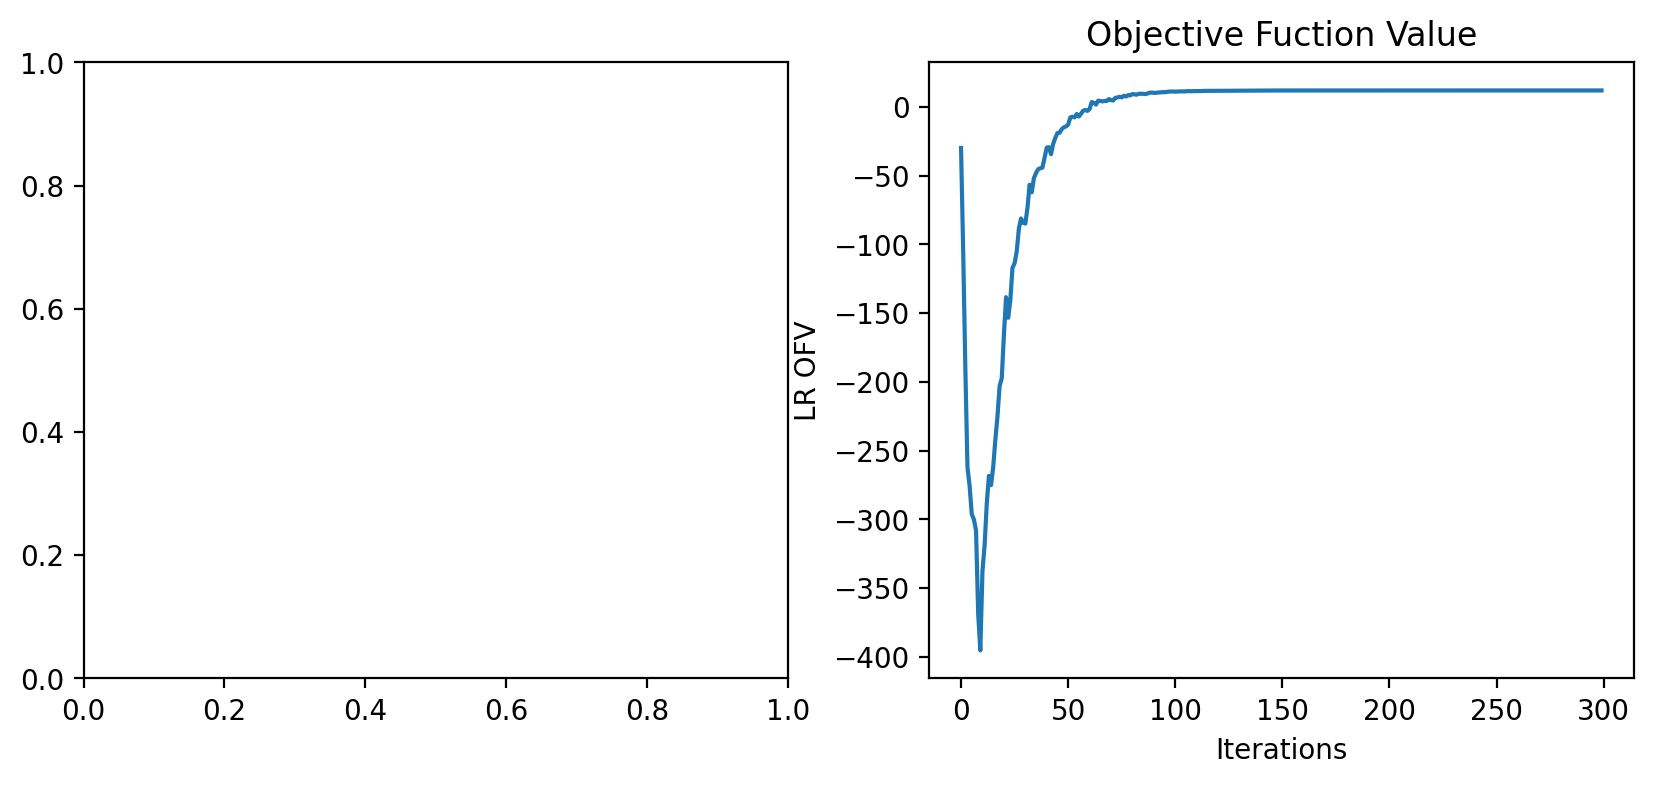

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

# ax[0].plot(multipliers_to_plot[:iteration])
# ax[0].set(xlabel='Iterations', ylabel='Lagragian Multipliers', title='Lagragian Multipliers')
# ax[0].legend(['v1-v2 at t=1 (d=2)', 'v2-v1 at t=1 (d=9)', 'v1-v2 at t=2 (d=3)', 'v2-v1 at t=2 (d=4)'])


ax[1].plot(ofv)
ax[1].set(xlabel='Iterations', ylabel='LR OFV', title='Objective Fuction Value')
plt.show()



# Assignment Problem Archive

In [ ]:
LAX_DTLA = schedule[schedule['od'] == 'LAX_DTLA'].reset_index(drop=True).reset_index()
LAX_DTLA['index'] = LAX_DTLA['index'].apply(lambda x: 'LAX_DTLA_' + str(x))

DTLA_LAX = schedule[schedule['od'] == 'DTLA_LAX'].reset_index(drop=True).reset_index()
DTLA_LAX['index'] = DTLA_LAX['index'].apply(lambda x: 'DTLA_LAX_' + str(x))

In [ ]:
LAX_DTLA['arrival_time'] = LAX_DTLA['schedule'] + 10
DTLA_LAX['arrival_time'] = DTLA_LAX['schedule'] + 10

In [ ]:
nodes = ['Source', 'Sink']
nodes.extend(LAX_DTLA['index']+'A')
nodes.extend(LAX_DTLA['index']+'B')
nodes.extend(DTLA_LAX['index']+'A')
nodes.extend(DTLA_LAX['index']+'B')

In [ ]:
edges = [('Source', 'Sink')]
cost = [-100]
for i in LAX_DTLA['index']:
    edges.append(('Source', i+'A'))
    cost.append(1)
    edges.append((i+'A', i+'B'))
    cost.append(0)
    edges.append((i+'B', 'Sink'))
    cost.append(0)
for i in DTLA_LAX['index']:
    edges.append(('Source', i+'A'))
    cost.append(1)
    edges.append((i+'A', i+'B'))
    cost.append(0)
    edges.append((i+'B', 'Sink'))
    cost.append(0)

for previous_task in LAX_DTLA.iterrows():
    for next_task in LAX_DTLA.iterrows():
        if previous_task[1]['arrival_time']+10 <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(-1)

for previous_task in DTLA_LAX.iterrows():
    for next_task in DTLA_LAX.iterrows():
        if previous_task[1]['arrival_time']+10 <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

for previous_task in LAX_DTLA.iterrows():
    for next_task in DTLA_LAX.iterrows():
        if previous_task[1]['arrival_time'] <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

for previous_task in DTLA_LAX.iterrows():
    for next_task in LAX_DTLA.iterrows():
        if previous_task[1]['arrival_time'] <= next_task[1]['schedule']:
            edges.append((previous_task[1]['index']+'B', next_task[1]['index']+'A'))
            cost.append(0)

In [ ]:
capacities = [GRB.INFINITY] + [1] * len(edges)
capacities = dict(zip(edges, capacities))

cost = dict(zip(edges, cost))
supply = {'Source': -20, 'Sink': 20}

In [ ]:
m = Model("MCNF")

flow = m.addVars(edges, obj=cost, name="flow", lb=0, ub=capacities)
for n in nodes:
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

for i, j in edges:
    if i.endswith('A') and j.endswith('B'):
        m.addConstr(flow[i, j] == 1, f"flow_{i}_to_{j}")

m.optimize()

if m.status == GRB.OPTIMAL:
    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j.endswith('A'))
    print("Sum of flow from Source to nodes with A:", flow_sum)
else:
    print("No optimal solution found.")
